High level story:

1. word cloud and barriers number histogram - what barriers do learners face? 
2. correlation, how do these barriers relate to each other? can we explore these relationships in more detail?
3. Likert diagrams to explore differences between programs/ regions, highlight interesting findings
4. visualise the flow of grads from bootcamp to 6months post-bootcamp. does placement speed vary per region? per programme? and how do the barriers factor in?



To do: 
1. understand the types of people that attend Generation bootcamps and how this profile varies according to programme (barriers they face, location, etc…)
    - Create a wordcloud with learner needs

2. Explore the distribution of learners in the UK:
    - Create a map to better understand where our learners are based.
    - Layer this with the jobs density data (from 2021)? maybe make a heatmap of "employed" grads to see if we 
      get more success with employment in the areas with higher jobs density?
      - (perhaps come back to this later)

2. Explore how barriers relate to placement  outcomes -
    - are there any barriers that appear to be more impactful than others? What about certain combinations of
      barriers? (Heatplot? What other plots or figures might I use?) -- adjust the correlation strategy.
    - Dive deeper into the barriers faced by the learners, specifically if a grad has English as an additional 
      language (EAL=1). How does reported EAL impact placement rate? Does this vary by programme? Are there 
      cohorts where EAL placement is much higher or much lower? if so what are the characteristics of these 
      programmes and how can we repeat or avoid similar scenarios?
    - Hypothesis is that EAL is more of a barrier for ITS and DA cohorts?
      
3. To supplement the above analysis I will also do a text analysis of feedback provided to generation from employers who chose not to hire grads due to EAL barriers. What are the themes in this data? 

4 March todo:
- Check the correlation figure. pearson correlation is not correct for categorical data. Chi square. for correlation also check out the seaborn mask attribute for heatmap.
- Read the resource on categorical data sent by Filipa, use this to create one figure. Likert scale
- Fill in the missing and nan values for the word cloud.

7 March todo:
- Check the correlation figure. pearson correlation is not correct for categorical data. Chi square. for correlation also check out the seaborn mask attribute for heatmap.
- Progress with Likert scale, can I create a figure with multi-categorical data? 
- Fill in the missing and nan values for the word cloud.
- Data cleaning: remove the cohorts that graduated within the past 6 months
- Data cleaning: Remove non-tech cohorts to clarify the story
- Create a Sankey figure that shows the grad journey from Enrolment status, employed_90 days, employed_180 days, current_employment_status
- Add ordinality to: Bariers count, Education Level,




## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

In [3]:
import plotly.graph_objects as go

In [20]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

## Reading data

In [4]:
PowerBI_df = pd.read_csv("Gen_Data/data_improved_including DE_AWS.csv")
SF_df = pd.read_csv("Gen_Data/Grad_attendance_info.xls.csv")

In [5]:
SF_df.rename(columns={"Learner Name":"LearnerName"}, inplace=True)

In [6]:
# merged_df = PowerBI_df.join(SF_df, on="LearnerName")

gen_df = pd.merge(PowerBI_df, SF_df, left_on='LearnerName', right_on='LearnerName')

Initial cleaning

In [7]:
gen_df["gender"].replace(to_replace=["Other/Prefer to self describe",
                                           "Other",
                                           "Non-binary",
                                           "Trans man",
                                           "Choose not to identify"],
                               value= "Other",
                               inplace=True)

In [8]:
gen_df["Employment_Status"].replace(to_replace="Placed",
                               value= "Employed",
                               inplace=True)

In [9]:
# Cleaning is_lone_parent

gen_df["is_lone_parent"].fillna(0, inplace=True)

In [10]:
# Cleaning Education Level in a way that maintains ordinality:

gen_df["Education level"].replace(to_replace=["Level 1",
                                           "Level 2",
                                           "Level 3",
                                           "Level 4",
                                           "Level 5",
                                           "Level 6",
                                           "Level 7",
                                           "Level 8",
                                           "Entry level",
                                           "Other"
                                          ],
                               value= [1, 2, 3, 4, 5, 6, 7, 8, None, None],
                               inplace=True)

In [11]:
# Cleaning Has_dependents:

gen_df["Has_dependents"].fillna(0, inplace=True)

In [12]:
# Cleaning Age at application:

gen_df["Age_at_application"].fillna(gen_df["Age_at_application"].median(), inplace=True)

Create a feature called search duration:

In [13]:
gen_df["First_Placement_Date"] = pd.to_datetime(gen_df["First_Placement_Date"], format= "%Y-%m-%d")

In [14]:
gen_df["Graduation Date"] = pd.to_datetime(gen_df["Graduation Date"], format= "%m/%d/%Y")

In [15]:
gen_df["Search_duration"] = gen_df["First_Placement_Date"] - gen_df["Graduation Date"]

In [16]:
Search_duration_noNaN = gen_df["Search_duration"].dropna()
Search_duration_noNaN_int = Search_duration_noNaN.dt.days

In [17]:
gen_df["Search_duration"] = gen_df["Search_duration"].dt.days

In [21]:
# Learner special needs wordcloud:
@interact
def wordcloud_by_programme(Prog_name=gen_df["ProgramName"].value_counts().index.tolist()):
    text = " ".join(i for i in gen_df["learnerSpecialNeedsDetails"][gen_df["ProgramName"]==Prog_name].astype(str))
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    plt.figure( figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

interactive(children=(Dropdown(description='Prog_name', options=('Technology - Cloud Operations Engineer', 'Te…

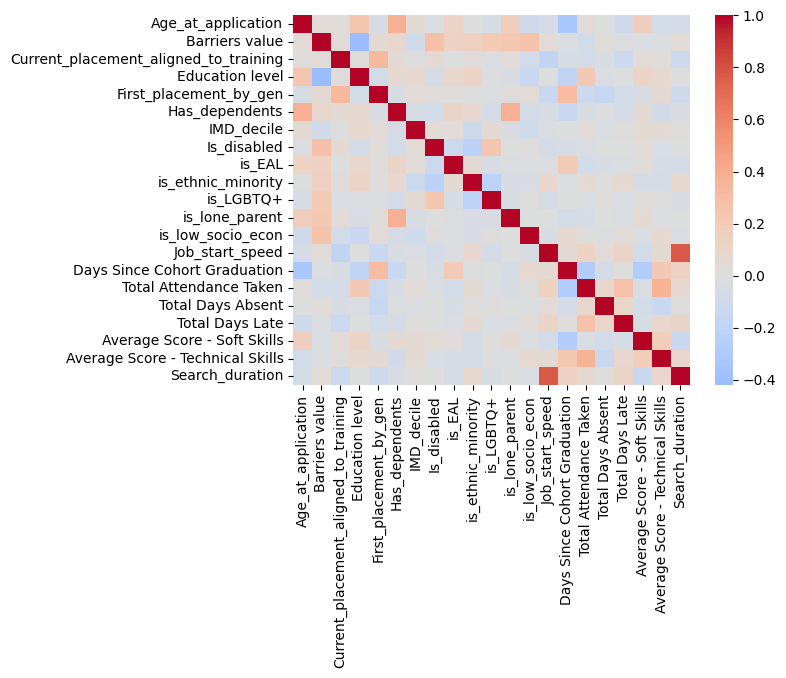

<Figure size 3000x3000 with 0 Axes>

In [22]:
# Create a correlation heatmap
gen_df_numeric = gen_df.select_dtypes(include=np.number)
gen_df_numeric= gen_df_numeric[['Age_at_application', 'Barriers value',
                               'Current_placement_aligned_to_training', 'Education level', 'First_placement_by_gen', 'Has_dependents','IMD_decile', 'Is_disabled', 'is_EAL', 'is_ethnic_minority',
                               'is_LGBTQ+', 'is_lone_parent', 'is_low_socio_econ', 'Job_start_speed',
                               'Days Since Cohort Graduation', 'Total Attendance Taken',
                               'Total Days Absent', 'Total Days Late', 'Average Score - Soft Skills',
                               'Average Score - Technical Skills', 'Search_duration']]

gen_data_matrix = gen_df_numeric.corr()
sns.heatmap(gen_data_matrix, 
            cmap='coolwarm',
            center=0)

plt.figure(figsize=(30, 30))
plt.show()

From this heatmat I would like to explore these relationships further:
1. The relationship between education level and barriers. Do people with higher levels of education have fewer barriers on average? What does this mean for our recruitment pipeline?
2. Average technical skill and attendance taken
3. Search duration and Average soft skills score
4. Search Duration and placement aligned to training programme

In [23]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [24]:
# Distribution of grads per programme and how many are EAL vs non-EAL:

@interact
def EAL_grads_per_programme_hist(Prog_name=gen_df["ProgramName"].value_counts().index.tolist()):
    sns.histplot(x=gen_df["is_EAL"][gen_df["ProgramName"]==Prog_name],
                bins=20,
                palette="pastel"
               )

    plt.title("Number of EAL vs non-EAL grads")
    plt.show()

interactive(children=(Dropdown(description='Prog_name', options=('Technology - Cloud Operations Engineer', 'Te…

In [49]:
# Create a stacked bar chart:

@interact
def stacked_barchart(barrier=["Is_30_or_over", 
                              "Is_disabled", 
                              "is_EAL", 
                              "is_ethnic_minority", 
                              "is_LGBTQ+", 
                              "is_lone_parent", 
                              "is_low_socio_econ",
                              "is_unempl_12+_mths",
                              "is_unemployed_pre_gen",
                              "is_unsatisfied_empl_pre_gen"
                             ]):
    # import libraries
    import matplotlib.patches as mpatches
    
    # set the figure size
    plt.figure(figsize=(10, 6))
    
    # from raw value to percentage
    grads_per_programme_count = gen_df.groupby('ProgramName')['Student_ID'].count().reset_index()
    EAL_per_programme = gen_df[gen_df["is_EAL"]==1].groupby('ProgramName')[barrier].sum().reset_index()
    EAL_per_programme[barrier] = [i / j * 100 for i,j in zip(EAL_per_programme[barrier], grads_per_programme_count['Student_ID'])]
    grads_per_programme_count['Student_ID'] = [i / j * 100 for i,j in zip(grads_per_programme_count['Student_ID'], grads_per_programme_count['Student_ID'])]
    
    # bar chart 1 -> top bars (group of 'smoker=No')
    bar1 = sns.barplot(y="ProgramName",  x="Student_ID", data=grads_per_programme_count, color='darkblue')
    
    # bar chart 2 -> bottom bars (group of 'smoker=Yes')
    bar2 = sns.barplot(y="ProgramName", x=barrier, data=EAL_per_programme, color='lightblue')
    
    # add legend
    top_bar = mpatches.Patch(color='darkblue', label=f'Not {barrier}')
    bottom_bar = mpatches.Patch(color='lightblue', label= f'{barrier}')
    plt.legend(handles=[top_bar, bottom_bar])
    
    # show the graph
    plt.show()

interactive(children=(Dropdown(description='barrier', options=('Is_30_or_over', 'Is_disabled', 'is_EAL', 'is_e…

In [28]:
@interact
def search_duration_hist(Prog_name=gen_df["ProgramName"].value_counts().index.tolist()):
    sns.displot(x=gen_df["Search_duration"][(gen_df["Search_duration"]>=0) & (gen_df["ProgramName"]==Prog_name)],
                bins=20,
                kde=True,
                hue=gen_df["is_EAL"],
                palette="pastel"
               )

    plt.title("Job search duration for Employed graduates")
    plt.show()

interactive(children=(Dropdown(description='Prog_name', options=('Technology - Cloud Operations Engineer', 'Te…

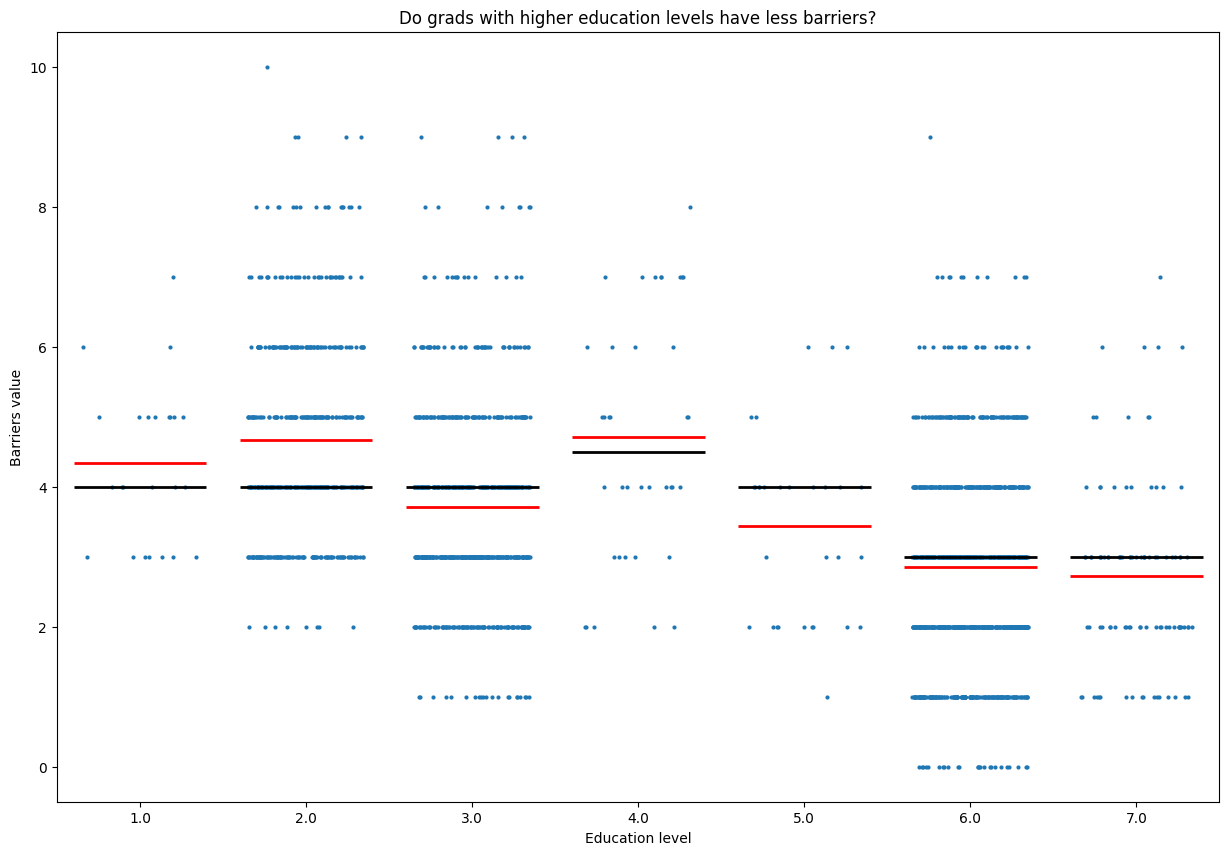

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(15,10))

sns.stripplot(data=gen_df[(gen_df["Employment_Status"]!="Internship") & (gen_df["Education level"]!=8)], 
              x="Education level",
              y="Barriers value",
              size= 3, 
              jitter=0.35, 
              ax=axs)

sns.boxplot(data=gen_df[(gen_df["Employment_Status"]!="Internship") & (gen_df["Education level"]!=8)], 
            x="Education level",
            y="Barriers value",
            ax=axs, 
            meanprops={'visible': True, 'color': 'r', 'ls': '-', 'lw': 2},
            medianprops={'visible': True, 'color': 'k', 'ls': '-', 'lw': 2}, whiskerprops={'visible': False}, 
            showmeans=True, meanline=True, showfliers=False, showbox=False, showcaps=False, zorder=10
           )

plt.title("Do grads with higher education levels have less barriers?")
plt.show()

In [30]:
@interact
def seducation_vs_barriers_hist(Prog_name=gen_df["ProgramName"].value_counts().index.tolist()):
    
    fig, axs = plt.subplots(1, 1, figsize=(15,10))
    
    sns.stripplot(data=gen_df[(gen_df["Employment_Status"]!="Internship") & (gen_df["Education level"]!=8) & (gen_df["ProgramName"]==Prog_name)], 
                  x="Education level",
                  y="Barriers value",
                  size= 3, 
                  jitter=0.35, 
                  ax=axs)
    
    sns.boxplot(data=gen_df[(gen_df["Employment_Status"]!="Internship") & (gen_df["Education level"]!=8)& (gen_df["ProgramName"]==Prog_name)], 
                x="Education level",
                y="Barriers value",
                ax=axs, 
                meanprops={'visible': True, 'color': 'r', 'ls': '-', 'lw': 2},
                medianprops={'visible': True, 'color': 'k', 'ls': '-', 'lw': 2}, whiskerprops={'visible': False}, 
                showmeans=True, meanline=True, showfliers=False, showbox=False, showcaps=False, zorder=10
               )
    
    plt.title("Do grads with higher education levels have less barriers?")
    plt.show()

interactive(children=(Dropdown(description='Prog_name', options=('Technology - Cloud Operations Engineer', 'Te…

In [ ]:
# Creating a Sankey diagram

In [33]:
# First generate the data for the Sankey diagram:

source_ = [] 
target_ = [] 
value_ = []

# For each gender determine the count of each employment status:
source_values_str = gen_df["gender"].value_counts().index.tolist()
target_values_str = gen_df["Employment_Status"].value_counts().index.tolist()

source_keys = {x:source_values_str.index(x) for x in source_values_str}
target_keys = {x:(target_values_str.index(x) + len(source_values_str)) for x in target_values_str}

for source_val in source_values_str:
    for target_val in target_values_str:
        count_temp = gen_df[gen_df["Employment_Status"]==target_val].groupby(gen_df["gender"]==source_val)["Employment_Status"].count()
        if True in count_temp:
            count_temp = count_temp[True]
            source_.append(source_keys[source_val])
            target_.append(target_keys[target_val])
            value_.append(count_temp)

In [35]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ['Male', 'Female', 'Other', 'Employed', 'Unemployed', 'Opted Out', 'Unknown'],
      color = "blue"
    ),
    link = dict(
      source = source_,
      target = target_,
      value = value_,
      # hovercolor=["midnightblue", "lightskyblue", "gold", "mediumturquoise", "lightgreen", "cyan"],
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show(renderer="iframe") 

In [54]:
def Sankey_data_preprocessing(source_feature, target_feature, data):
    source_ = [] 
    target_ = [] 
    value_ = []
    
    # Create a list of sources and a list of targest
    source_values_str = data[source_feature].value_counts().index.tolist()
    target_values_str = data[target_feature].value_counts().index.tolist()

    # Create a key value pair which can be used to transform the source and target strings into an int.
    source_keys = {x:source_values_str.index(x) for x in source_values_str}
    target_keys = {x:(target_values_str.index(x) + len(source_values_str)) for x in target_values_str}
    
    for source_val in source_values_str:
        for target_val in target_values_str:
            count_temp = data[data[target_feature]==target_val].groupby(data[source_feature]==source_val)[target_feature].count()
            if True in count_temp:
                count_temp = count_temp[True]
                source_.append(source_keys[source_val])
                target_.append(target_keys[target_val])
                value_.append(count_temp)

    return source_, target_, value_

In [43]:
gen_df["Employment_Status"].value_counts()

Employment_Status
Employed      1129
Unemployed     761
Opted Out      185
Unknown         51
Internship       2
Name: count, dtype: int64

In [55]:
Sankey_data_preprocessing("is_EAL", "Employment_Status", gen_df)

([0, 0, 0, 0, 1, 1, 1, 1, 1],
 [2, 3, 4, 5, 2, 3, 4, 5, 6],
 [707, 485, 122, 28, 422, 276, 63, 23, 2])

In [62]:
source_, target_, value_ = Sankey_data_preprocessing("is_EAL", "Employment_Status", gen_df[gen_df["ProgramName"] == "IT Support"])

In [63]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ['Not EAL', 'EAL', 'Employed', 'Unemployed', 'Opted Out', 'Unknown', 'Internship'],
      color = "blue"
    ),
    link = dict(
      source = source_,
      target = target_,
      value = value_,
      # hovercolor=["midnightblue", "lightskyblue", "gold", "mediumturquoise", "lightgreen", "cyan"],
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show(renderer="iframe") 

In [59]:
source_, target_, value_ = Sankey_data_preprocessing("Barriers value", "Employment_Status", gen_df)

In [60]:
gen_df["Barriers value"].value_counts()

Barriers value
3     667
4     605
2     446
5     346
1     211
6     186
7      74
8      30
0      25
9      11
10      1
Name: count, dtype: int64

In [61]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ['Not EAL', 'EAL', 'Employed', 'Unemployed', 'Opted Out', 'Unknown', 'Internship'],
      color = "blue"
    ),
    link = dict(
      source = source_,
      target = target_,
      value = value_,
      # hovercolor=["midnightblue", "lightskyblue", "gold", "mediumturquoise", "lightgreen", "cyan"],
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show(renderer="iframe") 